In [286]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [287]:
user_name = os.environ.get('DB_USER')
password = os.environ.get('DB_PASSWORD')
DB_NAME = 'BacterialGrowth'

# Database functions

In [288]:
def execute(phrase):
    """This function create a connection to the database and execute a command.
    :param phrase: str SQL sentence to execute
    :return: list of str received from the database after command execution.
    """
    try:
        cnx = mysql.connector.connect(user=user_name, password=password,host='localhost',database=DB_NAME)
        cnx.get_warnings = True
        cursor = cnx.cursor()
        cursor.execute(phrase)
        res = []
        for row in cursor:
            res.append(row)

        warnings = cursor.fetchwarnings()
        if warnings: 
            for i in range(len(warnings)):
                print("Warning - "+warnings[i][2])
        cursor.close()
        cnx.commit()
        cnx.close()
        return res
    except mysql.connector.Error as err:
        print("Something went wrong: {}".format(err))


In [289]:
def getRecords(table, field, args):
    where_clause = getWhereClause(args)
    phrase = "SELECT "+field+" FROM "+table+" "+where_clause
    res = execute(phrase)
    return res

In [290]:
def getFiles(field, args):
    where_clause = getWhereClause(args)
    phrase = "SELECT "+field+" FROM TechnicalReplicate "+where_clause
    res = execute(phrase)
    return res

In [393]:
def getWhereClause(args):
    clause = "WHERE ("
    for key, val in args.items():
        if val != 'null':
            clause = clause + key + "= '" + str(val) + "' AND "
        if val == 'null':
            clause = clause + key + " IS NULL AND "
    clause = clause[:-5] + ')'
    return clause

In [391]:
args = {'experimentId': '101', 'perturbationId': 'null'}
getWhereClause(args)

"WHERE (experimentId= '101')"

In [292]:
def getMatchingList (regex, lst):
    '''
    This function takes a regex expression and returns a list with all the matching words in the given lst
    '''
    res = []
    for word in lst:
        if regex.findall(word):
            res.append(word)
    return res

def getIntersectionColumns(df, columns):
    res = df[df.columns.intersection(columns)]
    return res

# General functions

In [293]:
def plotDf(df, ax):
    cmap = plt.get_cmap(name='tab10')
    msd_regex = re.compile(r'.*mean.* | .*std.*', flags=re.I | re.X)
    
    if len(getMatchingList(msd_regex, df)) > 0:
        vec = range(1,len(df.columns),2)
        for i in vec:
            ax.errorbar(df.iloc[:,0], df.iloc[:,i], yerr = df.iloc[:,i+1], color = cmap(i-1), label=df.columns[i][:-5])
    else:
        vec = range(1,len(df.columns))
        for i in vec:
            ax.plot(df.iloc[:,0], df.iloc[:,i], linestyle='-', color = cmap(i-1), label=df.columns[i])

In [295]:
def getMeanStd(files, regex=''):
    '''
    This function gets a df and the columns (regex or all columns) in which mean and std are going to be calculated
    For each header, 
    '''
    df = pd.read_csv(files[0][0], sep=" ")
    
    if regex != '':
        headers = getMatchingList(regex, df)
    else:
        headers = df.columns
    
    msd = pd.DataFrame(columns=range(1))
    msd.set_axis(['time'], axis='columns', inplace=True)
    msd['time'] = df['time']
    
    for header in headers:
        if header != 'time':
            df_header = pd.DataFrame(columns=range(len(files)+1)) #Each column will be the value from each file

            # Fill the df parsing all the records' files
            for i, file in enumerate(files, 1):
                file_df = pd.read_csv(file[0], sep=" ")
                df_header.iloc[:,i] = file_df[header]

            # Calculate and keep mean and std
            msd_header = pd.DataFrame(columns=range(3))
            msd_header.set_axis(['time', header+'_mean', header+'_std'], axis='columns', inplace=True)
            msd_header['time'] = file_df['time']
            msd_header[header+'_mean'] = df_header.iloc[:,1:].mean(axis=1, numeric_only=True)
            msd_header[header+'_std'] = df_header.iloc[:,1:].std(axis=1, numeric_only=True)

            msd = pd.merge(msd, msd_header, on='time')
    
    return msd

In [382]:
def plotPerturbation(files, plot_option, regex, num_ids, ax):
    if plot_option == 'mean_std_values':
        data = getMeanStd(files, regex=regex)
        
        if len(data.columns)>1: plotDf(data, ax)
        else: plt.close()
            
    elif plot_option == 'separate_values':
        for file in files:
            if num_ids <= 1:
                df = pd.read_csv(file[0], sep=" ")
                if regex == '':
                    data = df.copy()
                else: 
                    headers = getMatchingList(regex, df)
                    data = getIntersectionColumns(df, headers)
                
                if len(data.columns)>1: plotDf(data, ax)
                else: plt.close()
            elif num_ids > 1:            
                data = getMeanStd(files, regex=regex)
                
                if len(data.columns)>1: plotDf(data, ax)
                else: plt.close()

In [382]:
def plotPerturbation(files, plot_option, regex, num_ids, ax):
    data = getMeanStd(files, regex=regex)
    
    if len(data.columns)>1: plotDf(data, ax)
    else: plt.close()
            
    
        for file in files:
            if num_ids <= 1:
                df = pd.read_csv(file[0], sep=" ")
                if regex == '':
                    data = df.copy()
                else: 
                    headers = getMatchingList(regex, df)
                    data = getIntersectionColumns(df, headers)
                
                if len(data.columns)>1: plotDf(data, ax)
                else: plt.close()
            elif num_ids > 1:            
                data = getMeanStd(files, regex=regex)
                
                if len(data.columns)>1: plotDf(data, ax)
                else: plt.close()

In [371]:
abundance_options = ['od', 'counts', 'qpcr', 'rnaseq']
od_regex = re.compile(r'.*time.* | .*OD.*', flags=re.I | re.X)
counts_regex = re.compile(r'.*time.* | .*count.*', flags=re.I | re.X)
qpcr_regex = re.compile(r'.*time.* | .*qpcr.*', flags=re.I | re.X)
rnaseq_regex = re.compile(r'.*time.* | .*rna.*', flags=re.I | re.X)

def plotAbundances(files, plot_option, args):
    #files = getFiles('abundanceFile', args)

    if len(files) == 1:
        
        df = pd.read_csv(files[0][0], sep=" ")
        for opt in abundance_options:
            regex = globals()['%s_regex' % opt]
            headers = getMatchingList(regex, df)
            data = getIntersectionColumns(df, headers)
            
            # plot
            fig = plt.figure()
            ax = fig.add_subplot()
            if len(data.columns)>1: plotDf(data, ax)
            else: plt.close()
            plt.show()
            
    # If args is not replicateId => we have several replicates
    elif len(files) > 1:
        
        perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
        if len(perturbation_ids) <= 1:
            for opt in abundance_options:
                regex = globals()['%s_regex' % opt]
                
                fig = plt.figure()
                ax = fig.add_subplot()
                plotPerturbation(files, plot_option, regex, len(perturbation_ids), ax)
                plt.show()
        
        # Poner que si hay más de una perturbación o 
        # 1 experimento + sus perturbaciones, que lo separe también
        elif len(perturbation_ids) > 1:
            for opt in abundance_options:
                regex = globals()['%s_regex' % opt]
                
                fig = plt.figure()
                ax = fig.add_subplot()

                for pert_id in perturbation_ids:
                    args = {'perturbationId': pert_id[0]}
                    pert_files = getFiles('abundanceFile', args)
                    plotPerturbation(pert_files, plot_option, regex, len(perturbation_ids), ax)

                plt.show()
                
    
def plotMetabolites(files, plot_option, args):
    
    if len(files) == 1:
        data = pd.read_csv(files[0][0], sep=" ")
        
        # plot
        fig = plt.figure()
        ax = fig.add_subplot()
        if len(data.columns)>1: plotDf(data, ax)
        else: plt.close()
        plt.show()
            
    elif len(files) > 1:
        
        perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
        if len(perturbation_ids) <= 1:

            # plot
            fig = plt.figure()
            ax = fig.add_subplot()
            plotPerturbation(files, plot_option, '', len(perturbation_ids), ax)
            plt.show()
        
        elif len(perturbation_ids) > 1:
            fig = plt.figure()
            ax = fig.add_subplot()

            for pert_id in perturbation_ids:
                args = {'perturbationId': pert_id[0]}
                pert_files = getFiles('metabolitesFile', args)

                # plot
                plotPerturbation(pert_files, plot_option, '', len(perturbation_ids), ax)
                
            plt.show()
    
    
def plotPh(files, plot_option, args):
    #files = getFiles('phFile', args)
    
    if len(files) == 1:
        data = pd.read_csv(files[0][0], sep=" ")
        
        # plot
        fig = plt.figure()
        ax = fig.add_subplot()
        if len(data.columns)>1: plotDf(data, ax)
        else: plt.close()
        plt.show()
            
    elif len(files) > 1:
        perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
        if len(perturbation_ids) <= 1:
            
            # plot
            fig = plt.figure()
            ax = fig.add_subplot()
            plotPerturbation(files, plot_option, '', len(perturbation_ids), ax)
            plt.show()
        
        elif len(perturbation_ids) > 1:
            fig = plt.figure()
            ax = fig.add_subplot()

            for pert_id in perturbation_ids:
                args = {'perturbationId': pert_id[0]}
                pert_files = getFiles('phFile', args)

                # plot
                plotPerturbation(pert_files, plot_option, '', len(perturbation_ids), ax)

            plt.show()

# Plot trials

## Plot one replicate

## Plot several replicates from the same perturbation

### Separated values

## Plot several replicates from the same perturbation

### Mean and standard deviation values

## Plot several perturbations from the same experiment

## TO DO:

Pass color vector or something to differentiate experiments

# User input to get the args

In [374]:
# Get from other notebook with the user input
args = {'experimentId': '101'}

files = getFiles('abundanceFile', args)

In experimentId = 101 I have both replicated from the experiment itself and from one perturbation in the expeirment. I want to plot msd from exp and msd from perturbation. NOT IN SEPARATE VALUES, as if it was several perturbations.

This query works:
`SELECT * FROM TechnicalReplicate WHERE (experimentId= '101' AND perturbationId IS NULL);`

Do something similar in the getWhereClause or somewhere else

In [381]:
perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
perturbation_ids

files = getFiles('abundanceFile', args)
files

[('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/1/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/2/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/3/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/4/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/5/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/6/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/7/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/8/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/9/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/5/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experiments/101/101.1/4/abundance_file.txt',),
 ('/Users/julia/bacterialGrowth_thesis/Data/experimen

## Separate values

ABUNDANCES


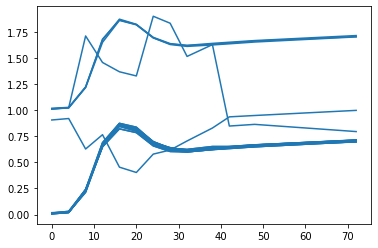

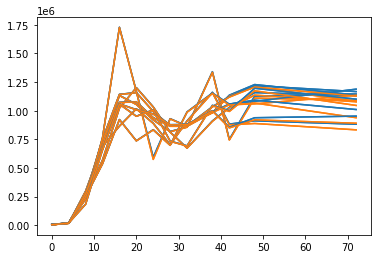

METABOLITES


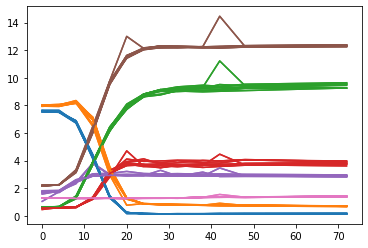

PH


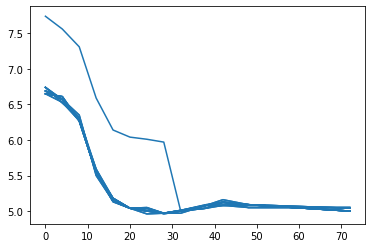

In [383]:
fields = ['abundance', 'metabolites', 'ph']
plot_option = 'separate_values'

print('ABUNDANCES')
if 'abundance' in fields: 
    files = getFiles('abundanceFile', args)
    plotAbundances(files, plot_option, args)
print('METABOLITES')    
if 'metabolites' in fields: 
    files = getFiles('metabolitesFile', args)
    plotMetabolites(files, plot_option, args)
print('PH')
if 'ph' in fields: 
    files = getFiles('phFile', args)
    plotPh(files, plot_option, args)

## Mean and standard deviation

ABUNDANCES


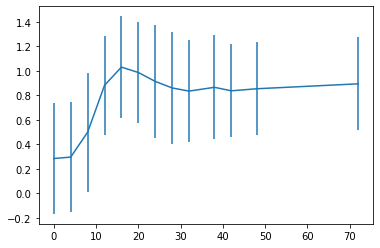

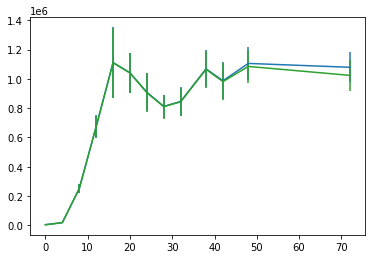

METABOLITES


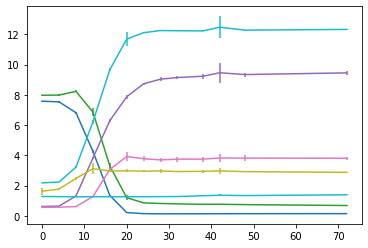

PH


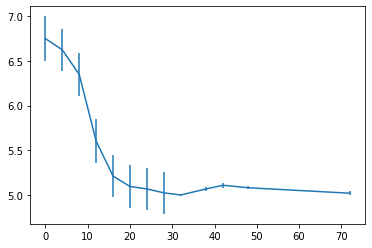

In [378]:
fields = ['abundance', 'metabolites', 'ph']
plot_option = 'mean_std_values'

print('ABUNDANCES')
if 'abundance' in fields: 
    files = getFiles('abundanceFile', args)
    plotAbundances(files, plot_option, args)
print('METABOLITES')    
if 'metabolites' in fields: 
    files = getFiles('metabolitesFile', args)
    plotMetabolites(files, plot_option, args)
print('PH')
if 'ph' in fields: 
    files = getFiles('phFile', args)
    plotPh(files, plot_option, args)